### A temperature forecasting problem

data present here: https://www.bgc-jena.mpg.de/wetter/

and here https://www.kaggle.com/stytch16/jena-climate-2009-2016


workbook copied from here:

https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.



In [42]:
import os

data_dir = '/Users/Vaibhav_Beohar/Documents/VB_Mck_Docs/Other Trainings/deeplearning_fchollet_examples/data_samples/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [43]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [44]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [45]:
float_data.shape

(420551, 14)

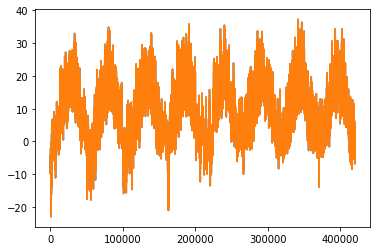

In [46]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius) - get all rows and 2nd column from the 2dvector  
plt.plot(range(len(temp)), temp)
plt.plot(range(len(temp)), temp)
plt.show()

# Temp is plotted for 420551 records - from 2009 until 2016 (144 datapoints per day - hence 2920.49 days - 
# 1 recording every 10 minutes)

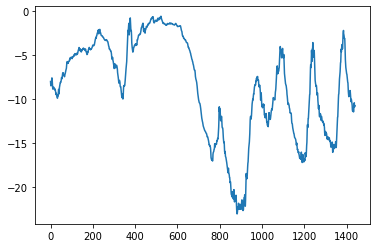

In [47]:
plt.plot(range(1440), temp[:1440])
plt.show()

### In below exercises, we are only focusing on preparation of data. 

Read more about generator() functions, how to loop thru sample data from generator() and how to perform feature engineering

Really cool stuff from F Chollet!

#### Preparing the data
The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

`
lookback = 720, i.e. our observations will go back 5 days
steps = 6, i.e. our observations will be sampled at one data point per hour
delay = 144, i.e. our targets will be 24 hours in the future`

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:



In [147]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [148]:
print(float_data.shape)
print(float_data.shape[-1])

(420551, 14)
14


### Following is an `insane` implementation of a generator function that generates a tuple of data and targets

* first create a 1d array of random 128 integers from `1440` (lookback - total images for last 5 days), to `max_index`
* then instantiate data 3d array and target 1d array. data array would be of dimension `(128, 240, 14)`. Target would be 128 index size
* the loop thru 1d array created in step one. extract the random element and the index at which it is using enumerate function 
        create range() of (random num - lookback, random number, step size of 6) [supposed to jump with 6 steps]
        fill the data array from the data original array, using range() in above step
        fill target data array from the data array first column

In [131]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    while 1:
        if shuffle:
            #create array of random int between [min_index + lookback] and [max_index], of size "batch_size" 
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size) 

        samples = np.zeros((len(rows), lookback // step, data.shape[-1])) #3d array of (128, 240, 14)
        targets = np.zeros((len(rows),))
        
#         print(rows.shape)
#         print(samples)
        print(samples.shape)
#         print(targets.shape)
        
        for j, row in enumerate(rows[:1]):
            indices = range(rows[j] - lookback, rows[j], step) #e.g. (random number - 1440, random num, 6)
#             print(indices)
#             print(j)
#             print(row)
            print(indices)
            print("printing here data[indices] --> ", data[indices].shape)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
#             print(samples[j].shape)
#             print(targets[j])
        yield samples, targets

In [132]:
train_gen
lookback = 1440
step = 6
delay = 144
batch_size = 128

##### Illustration of how a generator works and how to invoke it in a loop

In [135]:
num = 0
for train_gen in generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size):
    if num > 0 : 
         break 
    num = num + 1
#     print(num) 
#     print(type(train_gen[0]))
    arr = train_gen[1]
#     print(arr[0,0,:])
#     print(arr[0,0,:])
#     break
#     print(arr)

(128, 240, 14)
range(38461, 39901, 6)
printing here data[indices] -->  (240, 14)
(128, 240, 14)
range(198014, 199454, 6)
printing here data[indices] -->  (240, 14)


#### Or you can use python `next()` function to get one iteration from `generator()` function

In [139]:
a = next(generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size))

In [187]:
print(a[0].shape)
print(a[1].shape)

print()
print("printing sample temperaturers from data sample representing 24 hours ago. The [:, -1, 1] indexing means, \
we are getting all rows from samples, get the last row from the 2d sub-array (meaning get the 24 hr ago sample, \
and from those rows, get the 1st column that represents temperature)")
print()

data_sample = a[0]
print(data_sample[:, -1, 1])

print()
print("printing actual temperaturers")
target_sample = a[1]
print(target_sample)

(128, 240, 14)
(128,)

printing sample temperaturers from data sample representing 24 hours ago. The [:, -1, 1] indexing means, we are getting all rows from samples, get the last row from the 2d sub-array (meaning get the 24 hr ago sample, and from those rows, get the 1st column that represents temperature)

[ 1.02825778  0.96499881 -0.63341988 -0.14655172  0.58996347 -2.79213234
  0.80007363  0.7435924   0.22057625  0.31998321 -0.77575257  0.63853732
  1.35471926  1.24175681  0.49168613 -1.89859934 -1.14965829  0.49620463
  0.46796402 -0.21206994 -0.32277314 -2.12113537  0.01837346 -0.07312612
  1.05085027  0.23413174  0.82266612 -0.98134424  2.19064141 -1.23438013
  1.17510897  0.513149   -0.77575257 -0.03245964 -2.44533761 -0.2516068
 -1.50774926  1.47332984 -0.22223656  0.83735124  0.34935344 -0.51367969
  1.42814486  0.65774094  0.522186    0.25446499 -1.35186108  1.28468254
 -0.68312336  1.06779464 -0.44590222  0.83961049 -0.83336342 -1.27843548
 -1.26939849 -0.56338316 -0.056181

Sample of how to grab the last row from the entire 2d sub-array, and then get the first column of all those sub-2d arrays

In [182]:
x = np.array([[[1,2,3,4,5], [6,7,8,9,0], [11,22,33,44,55]], [[00,11,22,33,44], [1,2,3,4,5], [6,7,8,9,0]]])


print(x.shape)
print(x[:, -1, 1])


(2, 3, 5)
[22  7]


##### Below we create the right generic generator() function and invoke it properly - as provided by F Chollet

In [149]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [137]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size